## **Load python required libraries**

In [284]:
import numpy as np

import random

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.cm as cm1
from matplotlib import patches
from IPython.display import clear_output

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import scipy.stats

from google.colab import drive

# Mount your Drive folder to access the dataset
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Set the random seed**

In [285]:
seed = 1234 * 1

random.seed(seed)
np.random.seed(seed)

## **Definition of PIC class**

In [286]:
class PIC:
    def __init__(self, k, tol_centroids, learnable_params, tol_Loss, initial_learning_rate, decay_rate):
        #Model initialization
        self.k = k #Numbers of clusters to identify
        self.tol_centroids = tol_centroids #Tolerance for the change in the positions of centroids between consecutive clustering iterations

        self.learnable_params_current = learnable_params.copy() #Array that stores the current value of learnable parameters
        self.learnable_params = {} #Dictonay that stores the value of learnable parameters at each clustering iteration
        self.learnable_params[0] = self.learnable_params_current.copy()

        self.der_learnable_params_current = [0] * len(learnable_params) #Array that stores the current value of the derivative of
                                                                        #loss with respect to the learnable parameters
        self.der_learnable_params = {}#Array that stores the value of the derivative of
                                      #loss with respect to the learnable parameters at each clustering iteration

        self.der_learnable_params[0] = self.der_learnable_params_current.copy()

        self.tol_Loss = tol_Loss #Tolerance for the change in the loss between consecutive clustering iterations

        self.initial_learning_rate = initial_learning_rate #Initial value of the learning rate
        self.decay_rate = decay_rate #Exponential decay rate of the learning rate

        self.loss = {} #Dictionary that stores the value of loss at each clustering iteration

        return ;

    def centroid__init(self, data, seed):
        #Initialization of centroids and normalized porosity values at each centroid.
        #The first centroid is assigned to the data point that provides the minimum L2-norm of the input features.
        #The second centroid is assigned to the data point that provides the maximum L2-norm of the input features.
        #The rest of the centroids are randomly placed in data points that provided intermidaite values
        #for the L2-norm of the input features.
        random.seed(seed)
        np.random.seed(seed)

        self.centroids = {}
        for i in range(self.k):
            self.centroids[i] = np.zeros(data.shape[1], )

        index_min = np.argmin(np.sqrt(np.sum(data ** 2, axis = 1)))
        self.centroids[0] = data[index_min]

        index_max = np.argmax(np.sqrt(np.sum(data ** 2, axis = 1)))
        self.centroids[self.k - 1] = data[index_max]

        dist_min_max = np.linalg.norm(data[index_max] - data[index_min])

        if self.k > 2:
          index_rest = np.array([], dtype = int)
          while 1:
            if index_rest.shape[0] == self.k - 2:
              break
            else:
              index = random.randint(0, data.shape[0] - 1)
              if data[index, 0] * data[index, 1] > data[index_min, 0] * data[index_min, 1] and data[index, 0] * data[index, 1] < data[index_max, 0] * data[index_max, 1]:
                if index_rest.shape[0] == 0:
                  index_rest = np.append(index_rest, index)
                else:
                  for i in range(index_rest.shape[0]):
                    if 100 * abs(data[index_rest[i], 0] * data[index_rest[i], 1] - data[index, 0] * data[index, 1]) / (data[index_rest[i], 0] * data[index_rest[i], 1]) < 25.0:
                      break
                    elif i == index_rest.shape[0] - 1:
                      index_rest = np.append(index_rest, index)

          distances = [np.linalg.norm(data[index]) for index in index_rest]
          index_rest = index_rest[np.argsort(distances)]

          for i in range(1, self.k - 1):
              self.centroids[i] = data[index_rest[i - 1]]

        #Perform 1 iteration of k-means
        self.gs_data = np.zeros((data.shape[0], self.k)) #Array whose each row corresponds to the normalized distances of a data points from all centroids
        for i, featureset in enumerate(data):
            for j in range(self.k):
                self.gs_data[i, j] = np.linalg.norm(featureset - self.centroids[j])

            self.gs_data[i, :] = self.gs_data[i, :] / np.sum(self.gs_data[i, :])

        self.classifications = {} #Dictionary that stores the lists of the data points' input features assigned to a certain cluster.
                                  #Each element corresponds to list for a different cluster.

        self.classifications_ind = {} #Dictionary that stores the lists of the data points' indexes assigned to a certain cluster.
                                      #Each element corresponds to list for a different cluster.

        for i in range(self.k):
            self.classifications[i] = []
            self.classifications_ind[i] = []

        for i, featureset in enumerate(data):
            classification_data = np.argmin(self.gs_data[i, :])
            classification = classification_data

            self.classifications_ind[classification].append(i)
            self.classifications[classification].append(featureset)

        for centroid in self.centroids:
            self.centroids[centroid] = np.mean(self.classifications[centroid], axis = 0)

        distances = []
        for centroid in self.centroids:
            distances.append(np.sqrt(np.sum(self.centroids[centroid] ** 2)))

        index_rest = np.argsort(distances)
        cs = {}
        for i in range(self.k):
            cs[i] = self.centroids[index_rest[i]]

        self.centroids = cs.copy()

        #Assignemnt of normalized porosity values to each centroid based on the L2-norm value of their input features
        Ds = [np.linalg.norm(self.centroids[centroid]) for centroid in self.centroids]

        self.centroids_porosities = {}
        for i in range(self.k):
            self.centroids_porosities[i] = (Ds[i] - np.min(Ds)) / (np.max(Ds) - np.min(Ds))#i * 1.0 / (self.k - 1.0)

        return ;

    def cubic_poly_realroot(self, coeff):
        #Function used to solve the 3rd order polynomial equation with respect to porosity
        poly_roots = np.roots(coeff)

        for root in poly_roots:
            if np.imag(root) == 0.0:
                real_root = np.real(root)
                break

        return real_root;

    def porosity_calc(self, featureset, mode):
        #if mode = "learning", the function provides the coefficients of the 3rd order polyonomila equation with
        #respedct to porosity to calculate the first part of the loss function.
        #If mode = "fit", the function provides these coefficients to the "cubic_poly_realroot" to solve the 3rd order
        #polynomial equation with repsect to porosity.
        a = self.learnable_params_current[0] ** 3

        b = 3 * (self.learnable_params_current[0] ** 2) * featureset[0]

        c = 3 * self.learnable_params_current[0] * (featureset[0] ** 2) + (self.learnable_params_current[1] ** 3) * (featureset[1] ** 2)

        d = (featureset[0] ** 3)

        if mode == "learning":
          return a, b, c, d;
        elif mode == "fit":
          coeff = [a, b, c, d]
          porosity = self.cubic_poly_realroot(coeff)
          return porosity;

    def delta_func(self, index, param_index):
        #Function used to calculate the kronecker delta function
        if param_index == index:
          return 1;
        else:
          return 0;

    def der_param_calc(self, param_index, featureset, label):
        #Function used to calculate the derivative of the learnable parameters with respect to the first part of the loss function
        der_param = (3 * ((self.learnable_params_current[0] * label + featureset[0]) ** 2) * label) * self.delta_func(0, param_index)
        der_param = der_param + self.delta_func(1, param_index) * 3 * (self.learnable_params_current[1] ** 2) * (featureset[1] ** 2) * label
        der_param = der_param + self.delta_func(2, param_index) * 0.0

        return der_param;

    def loss_calc(self, data, iteration):
        #Function used to calculate the value of the loss function
        loss = 0
        for featureset, label in zip(data, self.porosities):

            a, b, c, d = self.porosity_calc(featureset, "learning")
            S = a * (label ** 3) + b * (label ** 2) + c * label + d

            loss = loss + S ** 2 / data.shape[0] + np.abs(self.learnable_params_current[1] - self.learnable_params_current[2] * self.learnable_params_current[0]) / data.shape[0]

        self.loss[iteration] = loss

        return ;

    def parameters_update(self, data, max_iter, batch_num, seed, iteration):
        #Update of learnable parameters
        loss1_previous = 1.0
        for iteration1 in range(max_iter):
            #Random shuffling of data and division into batches
            np.random.seed(seed * iteration1)

            shuffled_all = np.concatenate((data, self.porosities.reshape(-1, 1)), axis = 1)

            np.random.shuffle(shuffled_all)

            shuffled_data = shuffled_all[:, :data.shape[0]]
            shuffled_porosities = shuffled_all[:, -1]

            X_batches = np.split(shuffled_data, batch_num)
            y_batches = np.split(shuffled_porosities, batch_num)

            learning_rate = self.initial_learning_rate * np.exp(-self.decay_rate * iteration1) * np.exp(-self.decay_rate * iteration)

            for X, y in zip(X_batches, y_batches):
                learnable_params = self.learnable_params_current.copy()
                der_learnable_params = [0] * len(self.learnable_params_current)

                for j in range(len(self.learnable_params_current)):
                    for featureset, label in zip(X, y):

                        a, b, c, d = self.porosity_calc(featureset, "learning")
                        S = a * (label ** 3) + b * (label ** 2) + c * label + d

                        der_param = self.der_param_calc(j, featureset, label)

                        #Calculation of derivatives of the learnable parameters with respect to the first part of the loss function
                        der_learnable_params[j] = der_learnable_params[j] + (2 * S * der_param) / X.shape[0]

                        #Calculation of derivatives of the learnable parameters with respect to the second part of the loss function
                        der_learnable_params[j] = der_learnable_params[j] + np.sign(self.learnable_params_current[1] - self.learnable_params_current[2] * self.learnable_params_current[0]) * (self.delta_func(1, j)  - self.learnable_params_current[2]  * self.delta_func(0, j) - self.learnable_params_current[0]  * self.delta_func(2, j)) / X.shape[0]

                    #Update of learnable parameters using stochastic gradient descent
                    learnable_params[j] = learnable_params[j] - learning_rate * der_learnable_params[j]

                self.der_learnable_params_current = der_learnable_params.copy()
                self.learnable_params_current = learnable_params.copy()

            #Calculation of loss
            loss1 = 0
            for featureset, label in zip(data, self.porosities):
                a, b, c, d = self.porosity_calc(featureset, "learning")
                S = a * (label ** 3) + b * (label ** 2) + c * label + d
                loss1 = loss1 + S ** 2  / data.shape[0] + 1 * np.abs(self.learnable_params_current[1] - self.learnable_params_current[2] * self.learnable_params_current[0]) / data.shape[0]

            #Check convergence of the learnable parameters based on the loss value
            if np.abs(loss1 - loss1_previous) / loss1_previous < self.tol_Loss:
              break
            else:
              loss1_previous = loss1

        #Storage of the converged value of the learnable parameters and their derivatives with respect to the loss function
        #after this optimization step.
        self.der_learnable_params[iteration + 1] = self.der_learnable_params_current.copy()
        self.learnable_params[iteration + 1] = self.learnable_params_current.copy()

        return ;

    def plot_clusters(self, data, iteration, b1_true, b2_true, b3_true):
        clear_output(wait = True)

        fig, ax = plt.subplots(1, 5)
        fig.set_size_inches(80, 18)
        fig.tight_layout(pad = 10)

        fig.suptitle('Iteration %d' %iteration, fontsize = 30, fontweight = 'bold',)

        cm = plt.cm.get_cmap('jet')

        #Plot clusters
        cluster_labels = np.zeros(data.shape[0], dtype = int)
        for classification in self.classifications:
            for index in self.classifications_ind[classification]:
                cluster_labels[index] = classification

        im = ax[0].scatter(data[:, 0], data[:, 1], s = 200, c = cluster_labels, cmap = cm, edgecolors = "black", linewidths = 1.5)

        cbar = fig.colorbar(im, ax=ax[0])
        cbar.ax.tick_params(labelsize=30)
        cbar.ax.set_title(r'$\bf{C_{k}}$', fontsize = 30, fontweight='bold', rotation=0, pad = 23)

        #Plot centroids
        for centroid in model.centroids:
            if centroid == 0:
              ax[0].scatter(model.centroids[centroid][0], model.centroids[centroid][1],
                            marker="X",  s = 2000, color="black", linewidth=0.1, label = r'$\bf{m_{k}}$')
            else:
              ax[0].scatter(model.centroids[centroid][0], model.centroids[centroid][1],
                            marker="X",  s = 2000, color="black", linewidth=0.1)

        ax[0].tick_params(axis='both', which='major', labelsize=30)
        ax[0].set_xlabel(r'$\bf{Δc_{L,norm}}$', fontsize = 30, labelpad = 6)
        ax[0].set_ylabel(r'$\bf{α_{norm}}$', fontsize = 30, labelpad = 6)
        ax[0].legend(fontsize = 30)

        #Plot the evolution of the learnable parameters and the loss
        history_b1 = []
        history_b2 = []
        history_b3 = []
        history_loss = []
        iteration_num = []

        for iter in self.learnable_params:
            history_b1.append(self.learnable_params[iter][0])
            history_b2.append(self.learnable_params[iter][1])
            history_b3.append(self.learnable_params[iter][2])
            history_loss.append(self.loss[iter])

            iteration_num.append(iter)

        #Plot the evolution of β1
        ax[1].plot([0, iteration_num[-1]], [b1_true, b1_true], '--', linewidth = 4, color = 'black', label = r'$\bf{β1_{true}}$', zorder = 0)
        ax[1].plot(iteration_num, history_b1, linewidth = 4, color = 'dodgerblue', label = r'$\bf{β1}$', zorder = 1)

        ax[1].tick_params(axis='both', which='major', labelsize=30)
        ax[1].set_xlabel("Iteration", fontsize = 30, fontweight = 'bold', labelpad = 6)
        ax[1].legend(fontsize = 30)

        #Plot the evolution of β2
        ax[2].plot([0, iteration_num[-1]], [b2_true, b2_true], '--', linewidth = 4, color = 'black', label = r'$\bf{β2_{true}}$', zorder = 0)
        ax[2].plot(iteration_num, history_b2, linewidth = 4, color = 'dodgerblue', label = r'$\bf{β2}$', zorder = 1)

        ax[2].tick_params(axis='both', which='major', labelsize=30)
        ax[2].set_xlabel("Iteration", fontsize = 30, fontweight = 'bold', labelpad = 6)
        ax[2].legend(fontsize = 30)

        #Plot the evolution of β3
        ax[3].plot([0, iteration_num[-1]], [b3_true, b3_true], '--', linewidth = 4, color = 'black', label = r'$\bf{β3_{true}}$', zorder = 0)
        ax[3].plot(iteration_num, history_b3, linewidth = 4, color = 'dodgerblue', label = r'$\bf{β3}$', zorder = 1)

        ax[3].tick_params(axis='both', which='major', labelsize=30)
        ax[3].set_xlabel("Iteration", fontsize = 30, fontweight = 'bold', labelpad = 6)
        ax[3].legend(fontsize = 30)

        #Plot the evolution of loss
        ax[4].plot(iteration_num, history_loss, linewidth = 4, color = 'dodgerblue')

        ax[4].tick_params(axis='both', which='major', labelsize=30)
        ax[4].set_xlabel("Iteration", fontsize = 30, fontweight = 'bold', labelpad = 6)
        ax[4].set_ylabel("Loss", fontsize = 30, fontweight = 'bold', labelpad = 6)

        plt.show()

        return ;

    def fit(self,data, max_iter, batch_num, seed, b1_true, b2_true, b3_true):
        #Model fitting
        self.porosities = np.zeros(data.shape[0], ) #Normalized porosity values for each data point used of the optimization of the learnable parameters
        self.porosities_predicted = np.zeros(data.shape[0], ) #Normalized porosity values for each data point predicted by the ISA model
        self.centroids_porosities_predicted = np.zeros(self.k, ) #Normalized porosity values at each centroid

        self.gs = np.zeros((data.shape[0], self.k)) #Array whose each row corresponds to the difference between the normalized porosities of a data point and all the centroids
        self.gs_data = np.zeros((data.shape[0], self.k)) #Array whose each row corresponds to the normalized distances of a data points from all centroids
        self.gs_final = np.zeros((data.shape[0], self.k)) #Array whose each row corresponds to the value of the composite clustering criterion of a data point for all centroids

        self.weight_data = {} #Weighting factor of k-means clsutering criterion
        self.weight_porosity = {} #Weighting factor of physics similarity measure

        for iteration in range(max_iter):
            self.iteration_current = iteration #Variable that store the number of the current iteration

            prev_centroids = dict(self.centroids)

            #Calculate the loss in the current clustering iteration
            self.loss_calc(data, iteration)

            #Plot the clusters at the given clustering iteration
            self.plot_clusters(data, iteration, b1_true, b2_true, b3_true)

            if iteration > 0 and self.learnable_params_current[0] < 0:

              for i, featureset in enumerate(data):
                  self.porosities_predicted[i] = self.porosity_calc(featureset, "fit")

              for centroid in self.centroids:
                self.centroids_porosities_predicted[centroid] = np.mean(self.porosities_predicted[self.classifications_ind[centroid]])

              self.centroids_porosities = self.centroids_porosities_predicted.copy()

              for i in range(self.porosities_predicted.shape[0]):
                  for j in range(self.k):
                      self.gs[i, j] = np.linalg.norm(self.porosities_predicted[i] - self.centroids_porosities[j])

                  self.gs[i, :] = self.gs[i, :] / np.sum(self.gs[i, :])

              distances = []
              for centroid in self.centroids:
                  distances.append(np.sqrt(np.sum(self.centroids[centroid] ** 2)))

              index_rest = np.argsort(distances)
              cs = {}
              for i in range(self.k):
                  cs[i] = self.centroids[index_rest[i]]

              self.centroids = cs.copy()

              #########################
              Ds = [np.linalg.norm(self.centroids[centroid]) for centroid in self.centroids]

              self.centroids_porosities = {}
              for i in range(self.k):
                  self.centroids_porosities[i] = (Ds[i] - np.min(Ds)) / (np.max(Ds) - np.min(Ds))#i * 1.0 / (self.k - 1.0)#list(np.linspace(0.0, 1.0, self.k))
              #########################


            for i, featureset in enumerate(data):
                for j in range(self.k):
                    self.gs_data[i, j] = np.linalg.norm(featureset - self.centroids[j])

                self.gs_data[i, :] = self.gs_data[i, :] / np.sum(self.gs_data[i, :])


            self.classifications = {} #Dictionary that stores the lists of the data points' input features assigned to a certain cluster.
                                      #Each element corresponds to list for a different cluster.

            self.classifications_ind = {} #Dictionary that stores the lists of the data points' indexes assigned to a certain cluster.
                                          #Each element corresponds to list for a different cluster.
            for i in range(self.k):
                self.classifications[i] = []
                self.classifications_ind[i] = []

            #Perform clustering using the composite criterion
            for i, featureset in enumerate(data):

                #Choose the value of the weighting factors based on the loss value
                if iteration > 0:

                  self.weight_data[iteration] = 1.0 - 0.5 * np.exp(-self.loss[iteration] * 1)

                  self.weight_porosity[iteration] = 1.0 - self.weight_data[iteration]

                  self.gs_final[i, :] = self.weight_data[iteration] * self.gs_data[i, :] + self.weight_porosity[iteration] * self.gs[i, :]


                else:
                  self.weight_data[iteration] = 1.0
                  self.weight_porosity[iteration] = 1.0 - self.weight_data[iteration]
                  self.gs_final[i, :] = self.gs_data[i, :].copy()

                classification = np.argmin(self.gs_final[i, :])

                self.classifications_ind[classification].append(i)
                self.classifications[classification].append(featureset)
                self.porosities[i] = self.centroids_porosities[classification]

            #Update centroids
            for centroid in self.centroids:
                self.centroids[centroid] = np.mean(self.classifications[centroid], axis = 0)

            #Check for the loss' convergence and the centroids'convergence
            optimized = False
            if iteration > 0 and abs((self.loss[iteration] - self.loss[iteration - 1]) / self.loss[iteration-1]) < self.tol_Loss:
              for centroid in self.centroids:
                  if np.linalg.norm(self.centroids[centroid]-prev_centroids[centroid]) > self.tol_centroids:

                    self.der_learnable_params[iteration + 1] = self.der_learnable_params_current.copy()
                    self.learnable_params[iteration + 1] = self.learnable_params_current.copy()

                    break

                  elif centroid == self.k - 1:

                    for centroid in self.centroids:
                        self.centroids_porosities_predicted[centroid] = np.mean(self.porosities_predicted[self.classifications_ind[centroid]])

                    self.centroids_porosities = self.centroids_porosities_predicted.copy()

                    optimized = True

            else:
              self.parameters_update(data, max_iter, batch_num, seed, iteration)

            if optimized:
              break

        return ;

    def predict(self,data):
        #Use the model to identify clusters in new data
        porosities_predicted = np.zeros(data.shape[0], ) #Normalized porosity values for each data point predicted by the ISA mode

        for i, featureset in enumerate(data):
            porosities_predicted[i] = self.porosity_calc(featureset, "fit")

        gs = np.zeros((data.shape[0], self.k)) #Array whose each row corresponds to the difference between the normalized porosities of a data point and all the centroids
        for i in range(porosities_predicted.shape[0]):
            for j in range(self.k):
                gs[i, j] = np.linalg.norm(porosities_predicted[i] - self.centroids_porosities[j])

            gs[i, :] = gs[i, :] / np.sum(gs[i, :])

        gs_data = np.zeros((data.shape[0], self.k)) #Array whose each row corresponds to the normalized distances of a data points from all centroids
        for i, featureset in enumerate(data):
            for j in range(self.k):
                gs_data[i, j] = np.linalg.norm(featureset - self.centroids[j])

            gs_data[i, :] = gs_data[i, :] / np.sum(gs_data[i, :])


        gs_final = np.zeros((data.shape[0], self.k)) #Array whose each row corresponds to the value of the composite clustering criterion of a data point for all centroids

        classifications_pred = {} #Dictionary that stores the lists of the data points' input features assigned to a certain cluster.
                                  #Each element corresponds to list for a different cluster

        classifications_ind_pred = {} #Dictionary that stores the lists of the data points' indexes assigned to a certain cluster.
                                      #Each element corresponds to list for a different cluster.

        for i in range(self.k):
            classifications_pred[i] = []
            classifications_ind_pred[i] = []

        #Perform clustering using the composite criterion
        for i, featureset in enumerate(data):

            gs_final[i, :] = self.weight_data[self.iteration_current] * gs_data[i, :] + self.weight_porosity[self.iteration_current] * gs[i, :]
            classification = np.argmin(gs_final[i, :])

            classifications_ind_pred[classification].append(i)
            classifications_pred[classification].append(featureset)

        return classifications_pred, classifications_ind_pred;

## **Specify the path to the dataset.**

In [287]:
#In this case they are stored in a folder inside the Colab Notebooks folder of Google drive.
path = '/content/drive/My Drive/Colab Notebooks/PIC/'

data_vel_all = np.loadtxt('{}wavespeed.txt'.format(path)) #Wave speed measurement
data_att_all = np.loadtxt('{}attenuation.txt'.format(path)) #Attenuation measurement
data_porosity_all = np.loadtxt('{}porosity.txt'.format(path)) #Corresponding porosity levels for each wave speed/attenuation measurement

## **Select porosity levels from the dataset.**

<ipython-input-288-5e6b18378675>:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('jet')


Text(1777.281045751634, 0.5, 'Attenuation (1/m)')

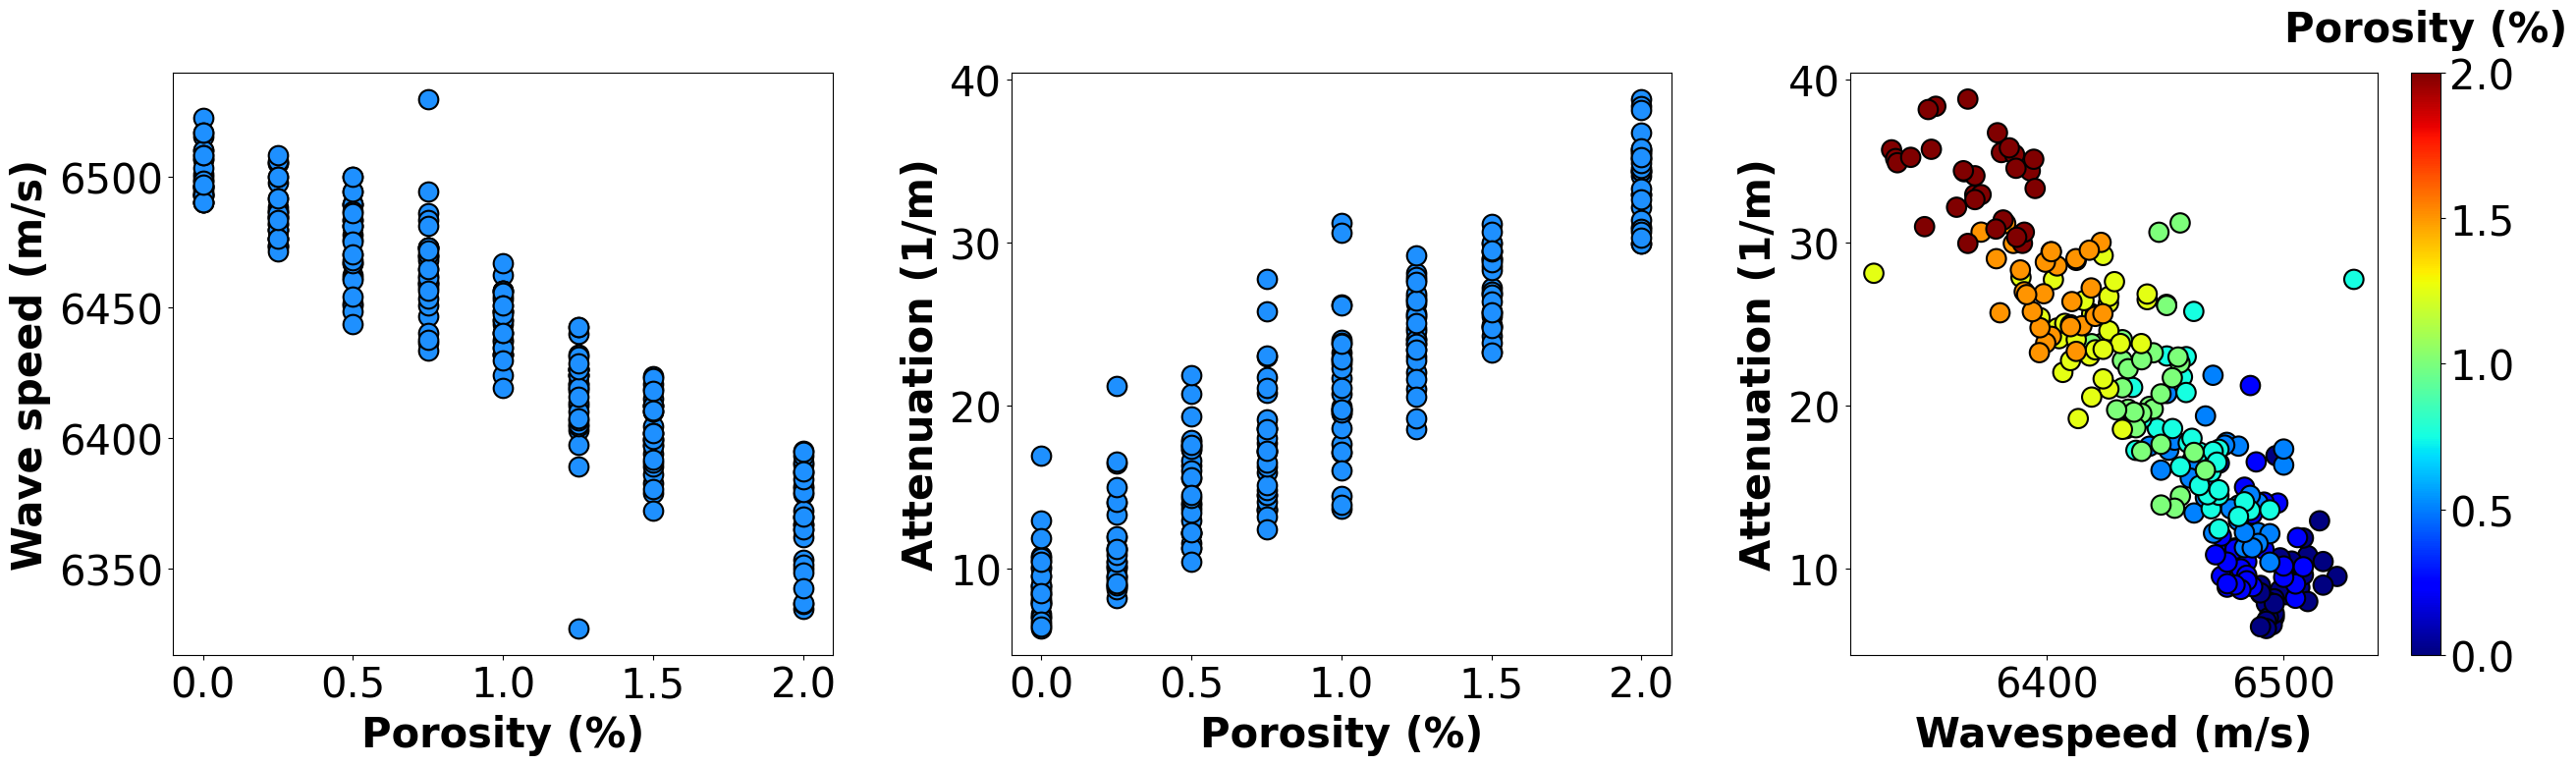

In [288]:
# If you want to select all the porosity levels. set the variable "selected_porosity_levels" to [0, 1, 2, 3, 4, 5, 6, 7].
#If you want just the first two and the last set "selected_porosity_levels" to [0, 1, 7] instead.
data_vel = data_vel_all.copy()
data_att = data_att_all.copy()
data_porosity = data_porosity_all.copy()

selected_porosity_levels = [0, 1, 2, 3, 4, 5, 6, 7]
selected_porosity_levels_indices = []
for i in range(data_vel.shape[0]):
    for j in range(len(selected_porosity_levels)):
        if np.floor(i / 30) == selected_porosity_levels[j]:
            selected_porosity_levels_indices.append(i)
            break

data_vel = data_vel[selected_porosity_levels_indices]
data_att = data_att[selected_porosity_levels_indices]
data_porosity = data_porosity[selected_porosity_levels_indices]

#Plot measurements
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(27, 9)
fig.tight_layout(pad = 10)

#Wave speed vs porosity
ax[0].scatter(data_porosity, data_vel, s = 200, color = 'dodgerblue', edgecolors = "black", linewidths = 1.5)

ax[0].tick_params(axis='both', which='major', labelsize=30)
ax[0].set_xlabel('Porosity (%)', fontsize = 30, fontweight='bold', labelpad = 6)
ax[0].set_ylabel('Wave speed (m/s)', fontsize = 30, fontweight='bold', labelpad = 6)

#Attenuation vs porosity
ax[1].scatter(data_porosity, data_att, s = 200, color = 'dodgerblue', edgecolors = "black", linewidths = 1.5)

ax[1].tick_params(axis='both', which='major', labelsize=30)
ax[1].set_xlabel('Porosity (%)', fontsize = 30, fontweight='bold', labelpad = 6)
ax[1].set_ylabel('Attenuation (1/m)', fontsize = 30, fontweight='bold', labelpad = 6)

#Wave speed-Attenuation vs porosity
cm = plt.cm.get_cmap('jet')

im = ax[2].scatter(data_vel, data_att, s = 200, c = data_porosity, cmap = cm, edgecolors = "black", linewidths = 1.5)

cbar = fig.colorbar(im, ax=ax[2])
cbar.ax.tick_params(labelsize=30)
cbar.ax.set_title('Porosity (%)', fontsize = 30, fontweight='bold', rotation=0, pad = 23)

ax[2].tick_params(axis='both', which='major', labelsize=30)
ax[2].set_xlabel('Wavespeed (m/s)', fontsize = 30, fontweight='bold', labelpad = 6)
ax[2].set_ylabel('Attenuation (1/m)', fontsize = 30, fontweight='bold', labelpad = 6)

## **Map porosity levels to porosity labels between 0 and 7.**

In [289]:
#This step is required for the evaluation of the clustering performance.
porosity_values = np.unique(data_porosity)
data_porosity_label = np.zeros(len(data_porosity), dtype = int)
for i in range(data_porosity.shape[0]):
    data_porosity_label[i] = np.where(porosity_values == data_porosity[i])[0][0]

## **Trasnformation of measurements to input features**

<ipython-input-290-7e88eaa3519b>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('jet')


Text(0, 0.5, '$\\bf{α_{norm}}$')

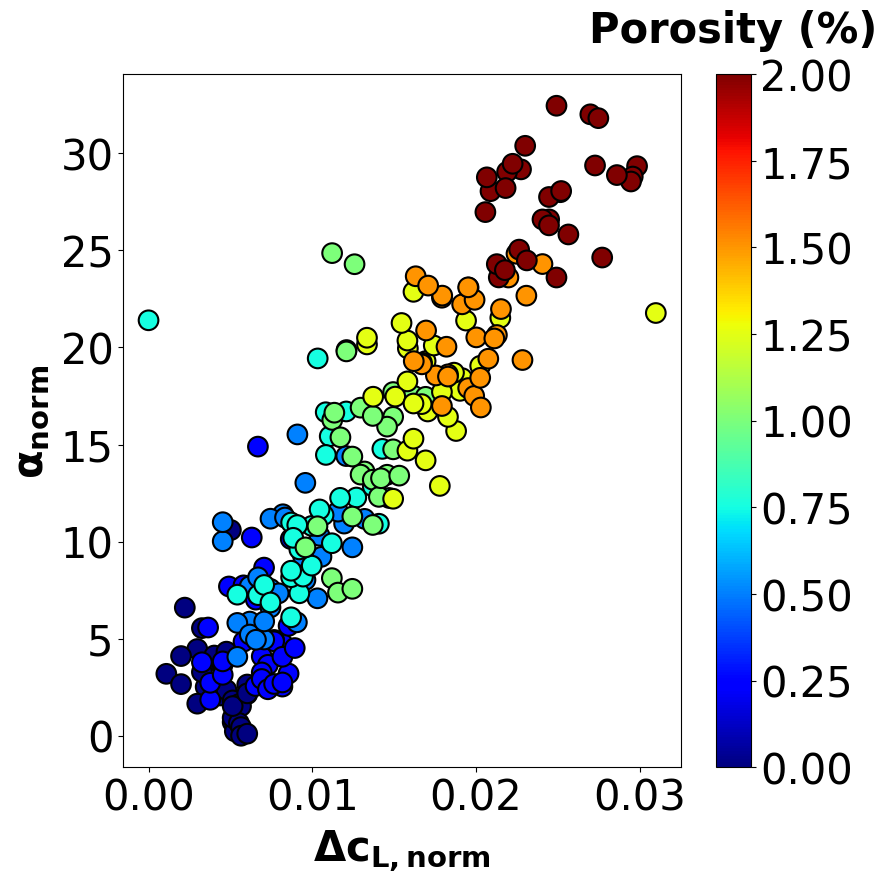

In [290]:
#Tranforsm wave speed measurements to the first input feature denoted as DcL
c_L = np.max(data_vel)
DcL =  (c_L-data_vel)/c_L

#Tranforsm attenuation measurements to the second input feature denoted as a
a = data_att - np.min(data_att)

#Assemble input feature array denoted as X
X = np.append(DcL.reshape(-1, 1), a.reshape(-1, 1), axis=1)

#Plot dataset
plt.figure(0, figsize = (9, 9))
ax = plt.axes()

cm = plt.cm.get_cmap('jet')

plt.scatter(X[:, 0], X[:, 1], s = 200, c = data_porosity, cmap = cm, edgecolors = "black", linewidths = 1.5)

cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=30)
cbar.ax.set_title('Porosity (%)', fontsize = 30, fontweight='bold', rotation=0, pad = 23)

plt.tick_params(axis='both', which='major', labelsize=30)
plt.xlabel(r'$\bf{Δc_{L,norm}}$', fontsize = 30, labelpad = 6)
plt.ylabel(r'$\bf{α_{norm}}$', fontsize = 30, labelpad = 6)

## **Split the data and the the true porosity levels and labels into a training and a testing set.**

In [291]:
#In this case the variable "split" is set to 0.2, indicating that 20% of the data are used to form the testing set.
split = 0.2
X_train, X_test, data_porosity_label_train, data_porosity_label_test, data_porosity_train, data_porosity_test = train_test_split(X, data_porosity_label, data_porosity, test_size = split, random_state = seed, shuffle=True)

## **Scaling of the input features in the training set and the testing set between 0 to 1, based on the min-max values from the training set.**

<ipython-input-292-c0cd1acde3bb>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('jet')
<ipython-input-292-c0cd1acde3bb>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('jet')


Text(0.5, 1.0, 'Testing set')

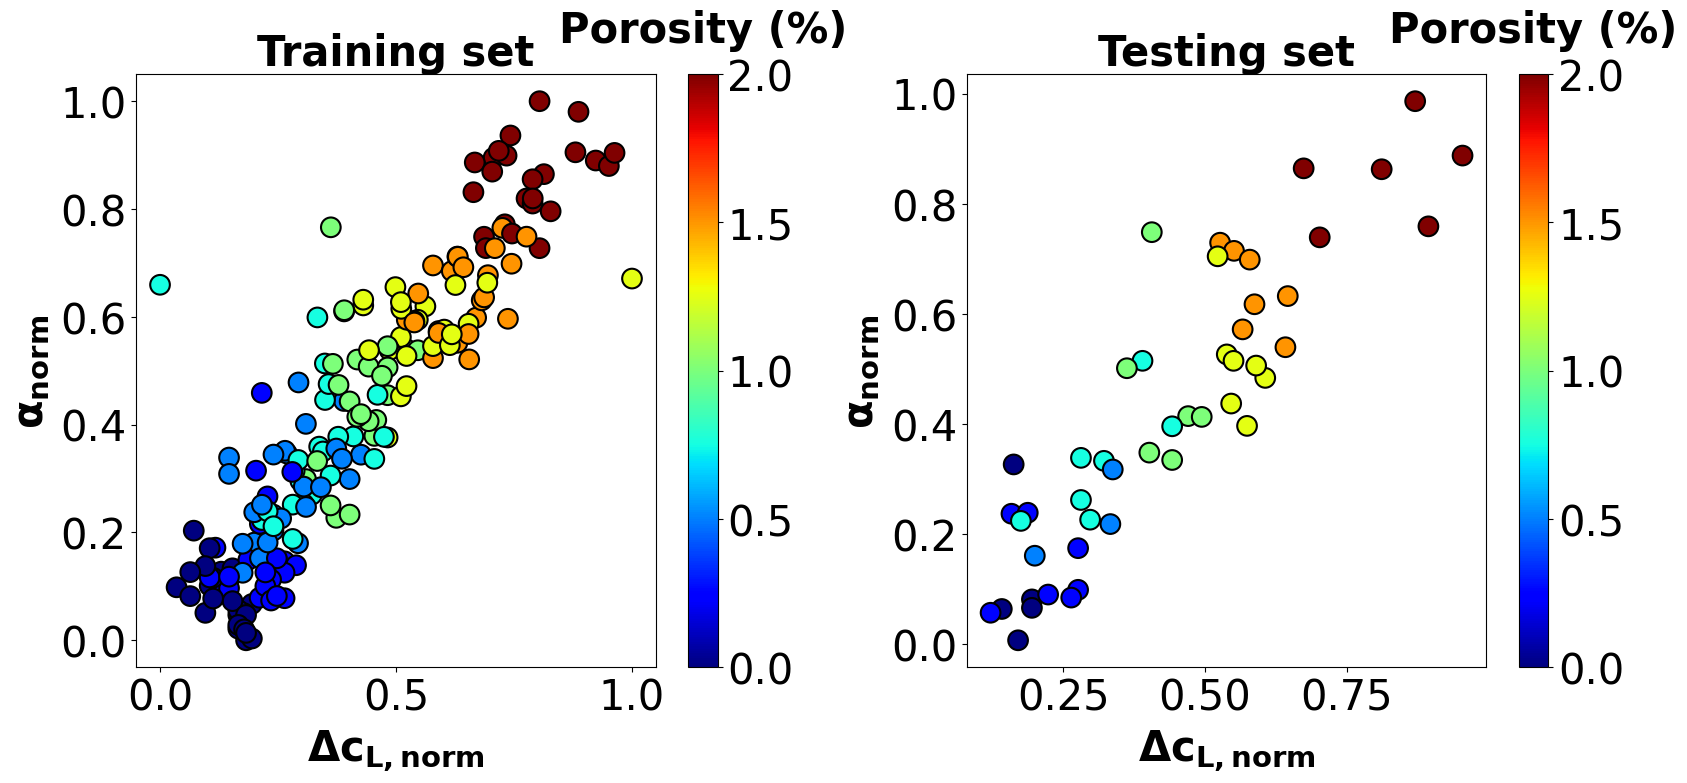

In [292]:
mmax = X_train.max(axis = 0)

X_train = X_train / mmax
X_test = X_test / mmax

#Plot the training set and the the testing set.
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(18, 9)
fig.tight_layout(pad = 10)

#Training set
cm = plt.cm.get_cmap('jet')

im1= ax[0].scatter(X_train[:, 0], X_train[:, 1], s = 200, c = data_porosity_train, cmap = cm, edgecolors = "black", linewidths = 1.5)

cbar1 = fig.colorbar(im1, ax=ax[0])
cbar1.ax.tick_params(labelsize=30)
cbar1.ax.set_title('Porosity (%)', fontsize = 30, fontweight='bold', rotation=0, pad = 23)

ax[0].tick_params(axis='both', which='major', labelsize=30)
ax[0].set_xlabel(r'$\bf{Δc_{L,norm}}$', fontsize = 30, labelpad = 6)
ax[0].set_ylabel(r'$\bf{α_{norm}}$', fontsize = 30, labelpad = 6)
ax[0].set_title('Training set', fontsize = 30, fontweight='bold')

#Testing set
cm = plt.cm.get_cmap('jet')

im2 = ax[1].scatter(X_test[:, 0], X_test[:, 1], s = 200, c = data_porosity_test, cmap = cm, edgecolors = "black", linewidths = 1.5)

cbar2 = fig.colorbar(im2, ax=ax[1])
cbar2.ax.tick_params(labelsize=30)
cbar2.ax.set_title('Porosity (%)', fontsize = 30, fontweight='bold', rotation=0, pad = 23)

ax[1].tick_params(axis='both', which='major', labelsize=30)
ax[1].set_xlabel(r'$\bf{Δc_{L,norm}}$', fontsize = 30, labelpad = 6)
ax[1].set_ylabel(r'$\bf{α_{norm}}$', fontsize = 30, labelpad = 6)
ax[1].set_title('Testing set', fontsize = 30, fontweight='bold')

## **Calculation of learnable parameters' true values**

In [293]:
v = 0.33415061080405445

kL = 4811.354247623511

q = np.sqrt(2 * (1 - v) / (1 - 2 * v))

#Calculation of material dependent constants
A = (2 - (3 / 4) * q ** 2) + 5 / (1 - (9 / 4) * q ** 2)

B = - ((16 / 15) - (5 / 12) * q ** 2 + (3 / 16) * q ** 4) \
    + (7 / 15) / (1 - (19 / 12) * q ** 2) \
    - (5 / 9) * (5 - (9 / 4) * q ** 2) / ((1 -(9 / 4) * q ** 2) ** 2)

C = ((4 / 9) - (1 / 2) * q ** 2 + (2 / 9) * q ** 3 + (3 / 16) * q **4) \
    + (5 / 3) * (1 + (3 / 2) * q ** 5) / ((1 -(9 / 4) * q ** 2) ** 2)

#Calculation of learnable parameters' true values
dcL_max = mmax [0]
att_max = mmax [1]
p_max = np.max(data_porosity_train) / 100.0

b1_true = (A /2) * p_max / dcL_max

b2_true = ((B ** 3) / (2* (C ** 2) * (kL **2))) * (att_max ** 2) * p_max / (dcL_max ** 3)
b2_true = np.sign(b2_true) * (np.abs(b2_true) ** (1.0/ 3.0))

b3_true = b2_true/ b1_true

## **Model parameters**

In [294]:
k = 8 #Numbers of clusters to identify
tol_centroids  = 1e-4 #Tolerance for the change in the positions of centroids between consecutive clustering iterations
tol_Loss = 1e-2 #Tolerance for the change in the loss between consecutive clustering iterations

#Initialization of learnable parameters
b1_init = -np.random.uniform(0.0, 1.0)
-np.random.uniform(0.0, 1.0)
b2_init = -np.random.uniform(0.0, 1.0)
b3_init = np.random.uniform(0.0, 1.0)

learnable_params = [b1_init, b2_init, b3_init]

print("The true value for learnable parameter b1 is %.20f and the initial is chosen to be %.20f" %(b1_true, b1_init))
print("The true value for learnable parameter b2 is %.20f and the initial is chosen to be %.20f" %(b2_true, b2_init))
print("The true value for learnable parameter b3 is %.20f and the initial is chosen to be %.20f" %(b3_true, b3_init))

initial_learning_rate = 4.3e-2 #Initial value of the learning rate
decay_rate = 0.03 #Exponential decay rate of the learning rate

The true value for learnable parameter b1 is -0.52719866389919756156 and the initial is chosen to be -0.19151945037889228640
The true value for learnable parameter b2 is -0.22398612426132635811 and the initial is chosen to be -0.43772773900711448025
The true value for learnable parameter b3 is 0.42486094825185932722 and the initial is chosen to be 0.78535858371376920939


## **Model initialization**

In [295]:
model = PIC(k, tol_centroids, learnable_params, tol_Loss, initial_learning_rate, decay_rate)

## **Centroid initialization**

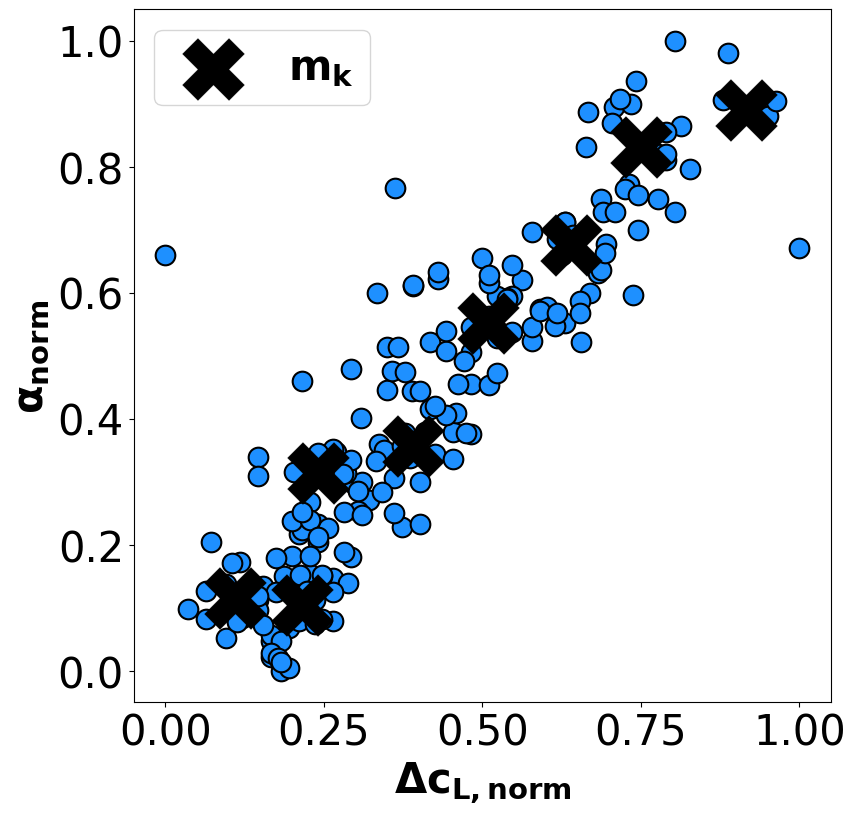

In [296]:
model.centroid__init(X_train, seed)

#Plot the initial position of centroids. The centroids are denoted as mk.
fig = plt.figure(0, figsize = (9, 9))

plt.scatter(X_train[:,0], X_train[:,1], s = 200, color = 'dodgerblue', edgecolors = "black", linewidths = 1.5)

for centroid in model.centroids:
    if centroid == 0:
      plt.scatter(model.centroids[centroid][0], model.centroids[centroid][1],
                marker="X",  s = 2000, color="black", linewidth=0.1, label = r'$\bf{m_{k}}$')
    else:
      plt.scatter(model.centroids[centroid][0], model.centroids[centroid][1],
                marker="X",  s = 2000, color="black", linewidth=0.1)

plt.tick_params(axis='both', which='major', labelsize=30)
plt.xlabel(r'$\bf{Δc_{L,norm}}$', fontsize = 30)
plt.ylabel(r'$\bf{α_{norm}}$', fontsize = 30, fontweight='bold')
plt.legend(fontsize = 30)

## **Model fitting**

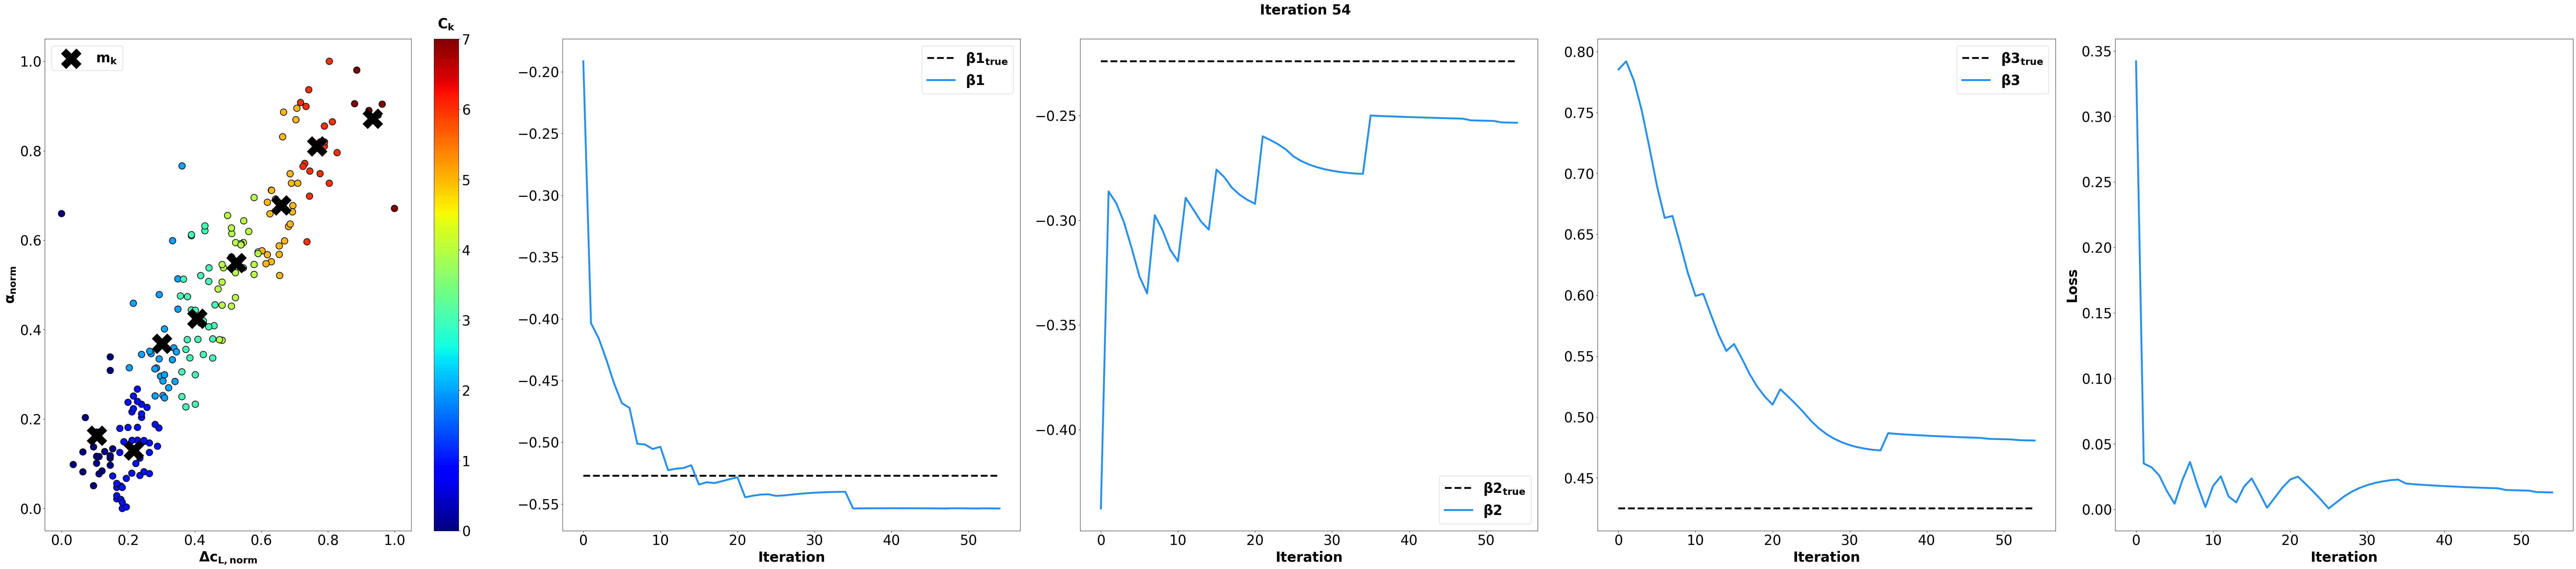

In [297]:
max_iter = 300 #Number of maximum clustering iterations
batch_num = 4 #Number of batches to divide the dataset into during the optimization of learnable parameters
model.fit(X_train, max_iter, batch_num, seed, b1_true, b2_true, b3_true)

In [298]:
model.learnable_params

{0: [-0.1915194503788923, -0.4377277390071145, 0.7853585837137692],
 1: [-0.40363236790523555, -0.28621317165745547, 0.7920928021373964],
 2: [-0.4158417582684034, -0.29183359954666294, 0.7763357052682097],
 3: [-0.43328550987447245, -0.3009716978529128, 0.752312447362338],
 4: [-0.4524892663011452, -0.3133458617428439, 0.7218908594779079],
 5: [-0.4682846186462691, -0.32674291933793237, 0.6896822388017236],
 6: [-0.47215808207584886, -0.33491753668312896, 0.6634877963760403],
 7: [-0.5012085480864342, -0.2975453647745175, 0.6651372299736051],
 8: [-0.5017939172368237, -0.30474806169538154, 0.6422951372352742],
 9: [-0.5054489900781477, -0.31407095939037244, 0.6184019378829191],
 10: [-0.50364093916038, -0.31954682305926163, 0.5994332369490567],
 11: [-0.522584407887113, -0.289208671989078, 0.6012229248455156],
 12: [-0.5214225675781006, -0.29483453175437363, 0.5840104678414881],
 13: [-0.520839053573523, -0.3005965474728809, 0.5674455189829428],
 14: [-0.5185682007097833, -0.304417898

## **Plot the evolution of learnable parameters**

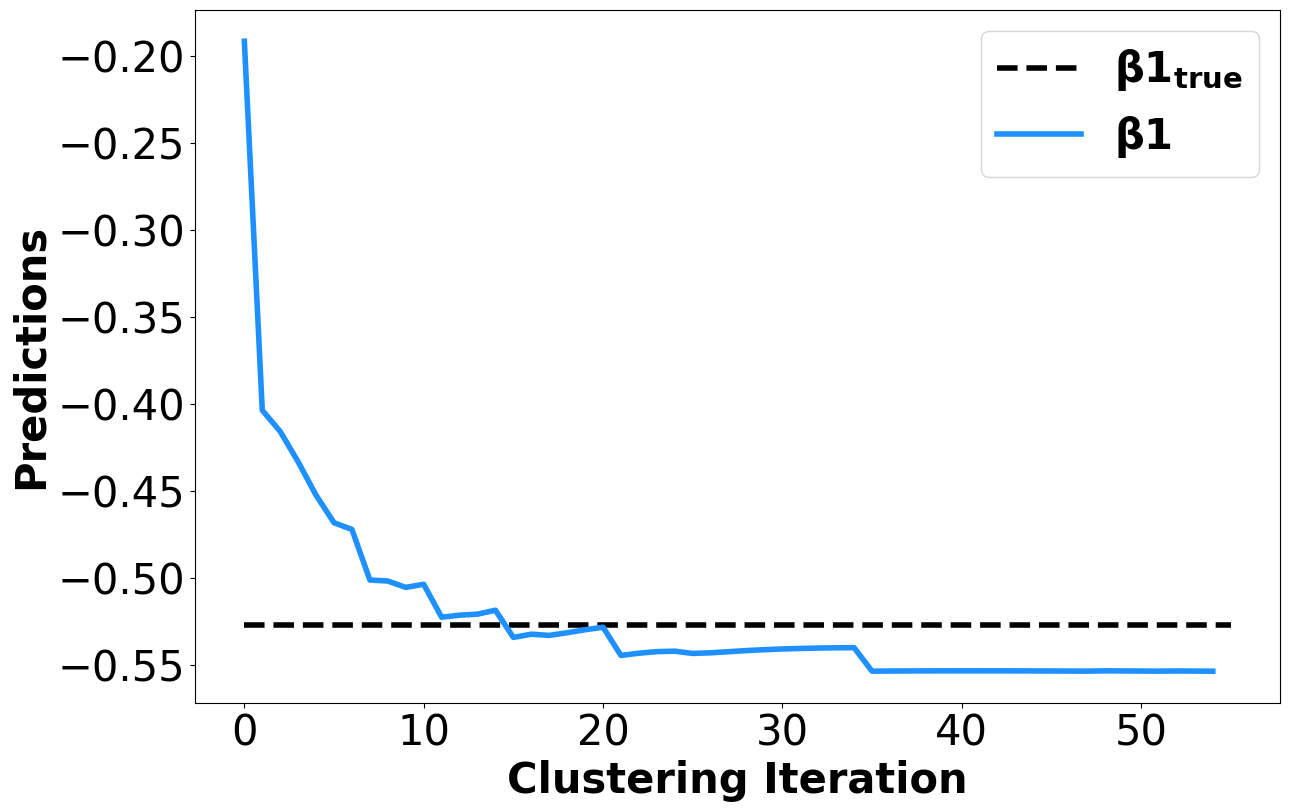

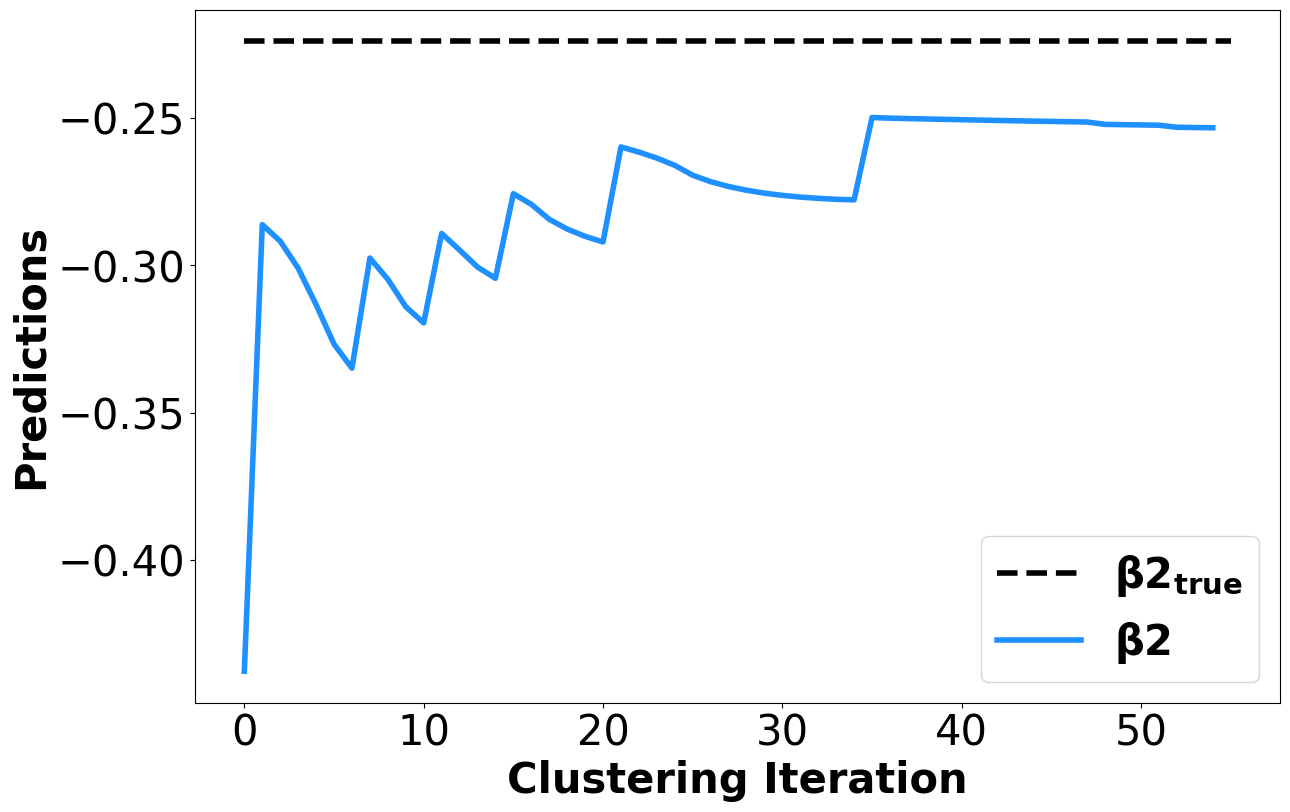

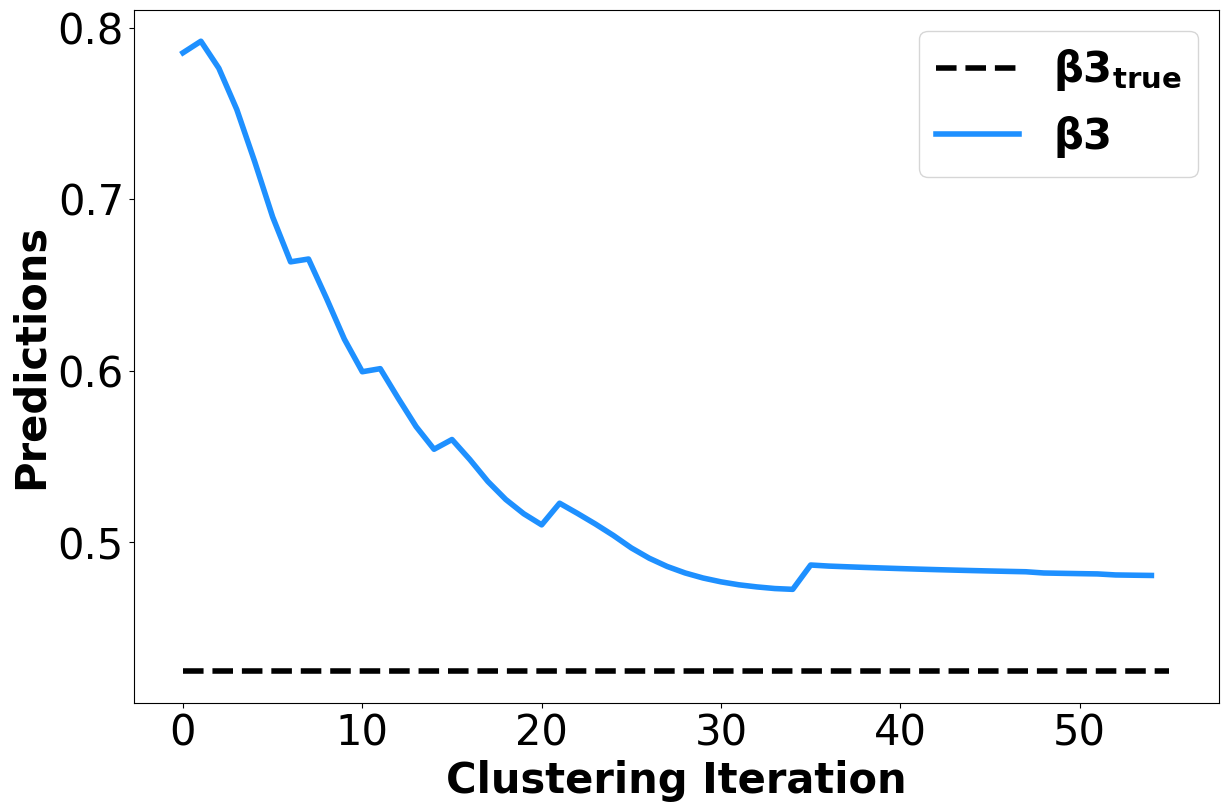

In [299]:
history_b1 = []
history_b2 = []
history_b3 = []
iteration_num = []

for iteration in model.learnable_params:
    history_b1.append(model.learnable_params[iteration][0])
    history_b2.append(model.learnable_params[iteration][1])
    history_b3.append(model.learnable_params[iteration][2])

    iteration_num.append(iteration)

#Evolution of β1
fig = plt.figure(0, figsize = (14, 9))

plt.plot([0, iteration_num[-1] + 1], [b1_true, b1_true], '--', linewidth = 4, color = 'black', label = r'$\bf{β1_{true}}$', zorder = 0)
plt.plot(iteration_num[:], history_b1[:], linewidth = 4, color = 'dodgerblue', label = r'$\bf{β1}$', zorder = 1)

plt.xlabel("Clustering Iteration", fontsize = 30, fontweight='bold')
plt.ylabel("Predictions", fontsize = 30, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=30)
plt.legend(fontsize = 30)

#Evolution of β2
fig = plt.figure(1, figsize = (14, 9))

plt.plot([0, iteration_num[-1] + 1], [b2_true, b2_true], '--', linewidth = 4, color = 'black', label = r'$\bf{β2_{true}}$', zorder = 0)
plt.plot(iteration_num[:], history_b2[:], linewidth = 4, color = 'dodgerblue', label = r'$\bf{β2}$', zorder = 1)

plt.xlabel("Clustering Iteration", fontsize = 30, fontweight='bold')
plt.ylabel("Predictions", fontsize = 30, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=30)
plt.legend(fontsize = 30)

#Evolution of β3
fig = plt.figure(2, figsize = (14, 9))

plt.plot([0, iteration_num[-1] + 1], [b3_true, b3_true], '--', linewidth = 4, color = 'black', label = r'$\bf{β3_{true}}$', zorder = 0)
plt.plot(iteration_num[:], history_b3[:], linewidth = 4, color = 'dodgerblue', label = r'$\bf{β3}$', zorder = 1)

plt.xlabel("Clustering Iteration", fontsize = 30, fontweight='bold')
plt.ylabel("Predictions", fontsize = 30, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=30)
plt.legend(fontsize = 30)

## **Relabelling of data points**

In [300]:
porosity_values_label = np.unique(data_porosity_label_train) #Variable that stores unique values of the true porosity labels (0-7) from the training set

porosity_values_propability = np.zeros((model.k, porosity_values_label.shape[0])) #Variable that stores in each row the probability of a cluster corresponding to a true porosity label
for classification in model.classifications:
    unique_values, counts = np.unique(data_porosity_label_train[model.classifications_ind[classification]], return_counts = True)
    for i in range(porosity_values_label.shape[0]):
        if len(np.where(unique_values == porosity_values_label[i])[0]) > 0:
          index = np.where(unique_values == porosity_values_label[i])[0][0]
          porosity_values_propability[classification, porosity_values_label[i]] = counts[index] / len(data_porosity_label_train[data_porosity_label_train == porosity_values_label[i]])
        else:
          porosity_values_propability[classification, porosity_values_label[i]] = 0

most_propable_true_clusters = []
for i in range(model.k):
    most_propable_true_clusters.append(np.flip(np.argsort(porosity_values_propability[i, :])))

most_propable_true_clusterss = []
index_most_propable_true_clusterss = []
for i in range(model.k):
    most_propable_true_clusterss.append(most_propable_true_clusters[i][0])
    index_most_propable_true_clusterss.append(0)

while 1:
  unique_valuess, countss = np.unique(most_propable_true_clusterss, return_counts = True)

  if len(unique_valuess) == model.k:
    break
  else:
    for i in range(len(unique_valuess)):
        if countss[i] > 1:
          indices = np.where(most_propable_true_clusterss == unique_valuess[i])[0]

          qq = np.argsort(porosity_values_propability[indices, unique_valuess[i]])

          most_propable_true_clusterss[indices[qq[0]]] = most_propable_true_clusters[indices[qq[0]]][index_most_propable_true_clusterss[indices[qq[0]]] + 1]

          index_most_propable_true_clusterss[indices[qq[0]]] = index_most_propable_true_clusterss[indices[qq[0]]] + 1

          break

#Relabelling of clusters for a consistent comparison with the true porosity labels
classifications_new = dict.fromkeys(list(range(model.k)), None)
classifications_ind_new = dict.fromkeys(list(range(model.k)), None)
centroids_new = dict.fromkeys(list(range(model.k)), None)
centroids_porosities_new = dict.fromkeys(list(range(model.k)), None)

for i in range(model.k):
    classifications_new[most_propable_true_clusterss[i]] = model.classifications[i]
    classifications_ind_new[most_propable_true_clusterss[i]] = model.classifications_ind[i]
    centroids_new[most_propable_true_clusterss[i]] = model.centroids[i]
    centroids_porosities_new[most_propable_true_clusterss[i]] = model.centroids_porosities[i]

model.classifications = classifications_new.copy()
model.classifications_ind = classifications_ind_new.copy()
model.centroids = centroids_new.copy()
model.centroids_porosities = centroids_porosities_new.copy()

## **Plot predicted clusters vs true clusters**

<ipython-input-301-d5673c2f13f6>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('jet')
<ipython-input-301-d5673c2f13f6>:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('jet')


Text(0.5, 1.0, 'True clusters')

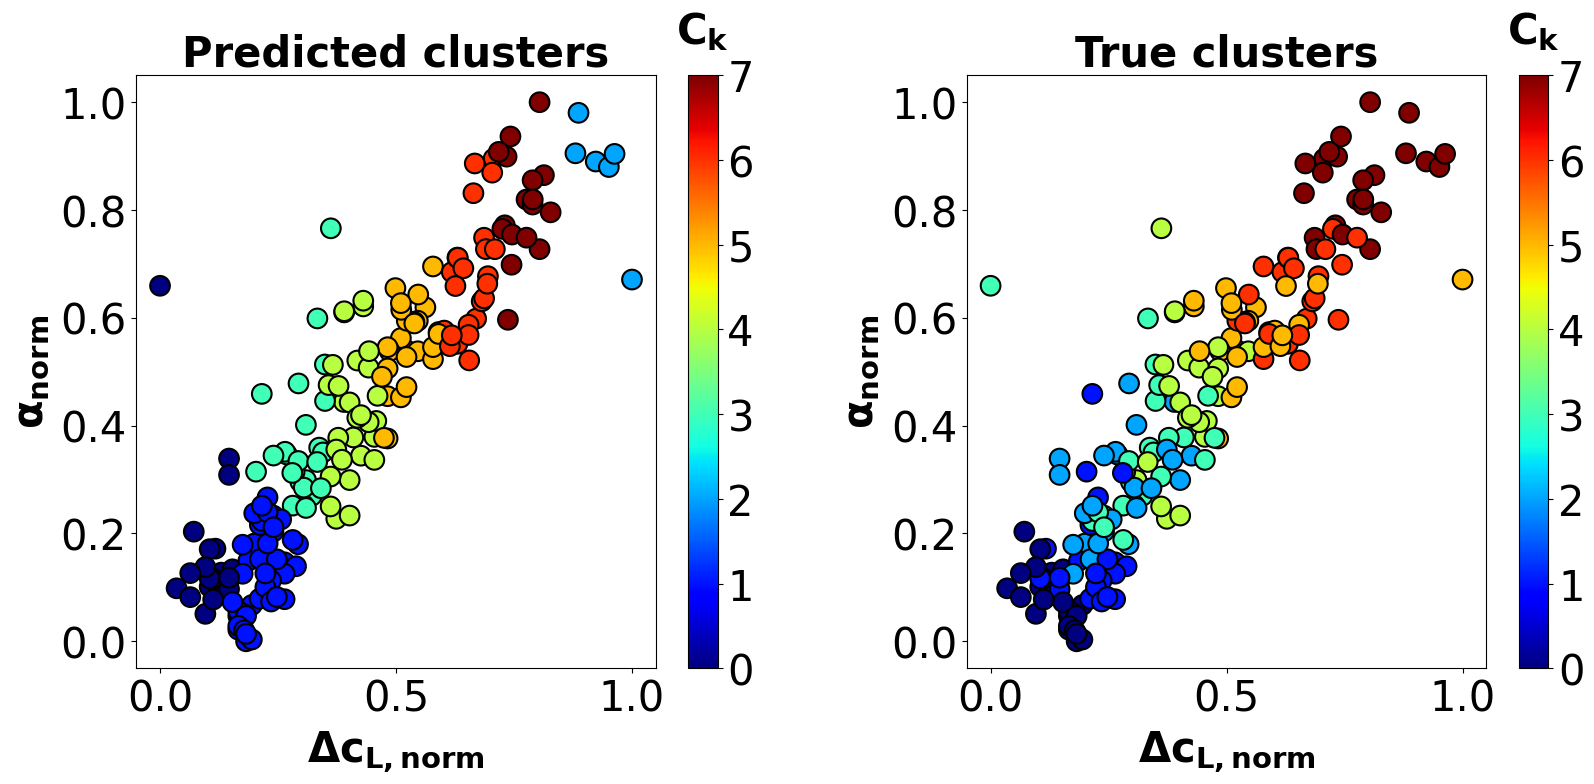

In [301]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(18, 9)
fig.tight_layout(pad = 10)

#Plot predicted clusters
cm = plt.cm.get_cmap('jet')

cluster_labels = np.zeros(X_train.shape[0], dtype = int)
for classification in model.classifications:
    for index in model.classifications_ind[classification]:
        cluster_labels[index] = classification

im1 = ax[0].scatter(X_train[:, 0], X_train[:, 1], s = 200, c = cluster_labels, cmap = cm, edgecolors = "black", linewidths = 1.5)

cbar1 = fig.colorbar(im1, ax=ax[0])
cbar1.ax.tick_params(labelsize=30)
cbar1.ax.set_title(r'$\bf{C_{k}}$', fontsize = 30, fontweight='bold', rotation=0, pad = 23)

ax[0].tick_params(axis='both', which='major', labelsize=30)
ax[0].set_xlabel(r'$\bf{Δc_{L,norm}}$', fontsize = 30, labelpad = 6)
ax[0].set_ylabel(r'$\bf{α_{norm}}$', fontsize = 30, labelpad = 6)
ax[0].set_title('Predicted clusters', fontsize = 30, fontweight='bold')

#Plot true clusters
cm = plt.cm.get_cmap('jet')

im2 = ax[1].scatter(X_train[:, 0], X_train[:, 1], s = 200, c = data_porosity_label_train, cmap = cm, edgecolors = "black", linewidths = 1.5)

cbar2 = fig.colorbar(im2, ax=ax[1])
cbar2.ax.tick_params(labelsize=30)
cbar2.ax.set_title(r'$\bf{C_{k}}$', fontsize = 30, fontweight='bold', rotation=0, pad = 23)

ax[1].tick_params(axis='both', which='major', labelsize=30)
ax[1].set_xlabel(r'$\bf{Δc_{L,norm}}$', fontsize = 30, labelpad = 6)
ax[1].set_ylabel(r'$\bf{α_{norm}}$', fontsize = 30, labelpad = 6)
ax[1].set_title('True clusters', fontsize = 30, fontweight='bold')

## **Functions for the creation of confusion matrices.**

In [302]:
def Coons(n_ksi, n_h):
    #Definition of function that partitions a domain using Coons partitioning
    nele = n_ksi*n_h
    nnodes = (n_ksi+1)*(n_h+1)
    ele = np.zeros((nele,4),dtype=int)
    nodes = np.zeros((nnodes,2))
    for i in range(0, n_ksi):
        for j in range(0, n_h):
            ele[j*n_ksi+i,0]=(n_ksi+1)*j+i+1
            ele[j*n_ksi+i,1]=ele[j*n_ksi+i,0]+1;
            ele[j*n_ksi+i,2]=ele[j*n_ksi+i,1]+n_ksi+1;
            ele[j*n_ksi+i,3]=ele[j*n_ksi+i,2]-1;

            nodes[ele[j*n_ksi+i,0]-1,:]=[i/n_ksi, j/n_h]
            nodes[ele[j*n_ksi+i,1]-1,:]=[(i+1)/n_ksi, j/n_h]
            nodes[ele[j*n_ksi+i,2]-1,:]=[(i+1)/n_ksi, (j+1)/n_h]
            nodes[ele[j*n_ksi+i,3]-1,:]=[i/n_ksi, (j+1)/n_h]
    mesh={'elements':ele, 'nodesC':nodes}

    return mesh;

def StraightLineDiv(startp, endp, div):
    ""
    if startp[0]!=endp[0]:
        X = startp[0]*(1-div)+endp[0]*div
        Y = startp[1]
    else:
        X = startp[0]
        Y = startp[1]*(1-div)+endp[1]*div
    p=np.array([X, Y])
    return p;

def ConfusionMatrix(k, classifications_ind, data_porosity_label):

    W = k #Matrix width
    H = k #Matrix height
    n_ksi = k #Number of divisions for matrix width
    n_h = k #Number of divisions for matrix height

    A=np.array([0, 0])
    B=np.array([W, 0])
    C=np.array([W, H])
    D=np.array([0, H])
    mesh = Coons(n_ksi, n_h)
    ele=mesh['elements'] #Array to store each element
    nodesC=mesh['nodesC'] #Nodal coordinates

    nodes = np.zeros(((n_ksi+1)*(n_h+1),2))

    for i in range(0, n_ksi*n_h):
        for j in range(0, 4):
            ksi=nodesC[ele[i,j]-1, 0]
            h=nodesC[ele[i,j]-1, 1]
            E0_ksi=1-ksi
            E1_ksi=ksi
            E0_h=1-h
            E1_h=h
            AB=StraightLineDiv(A, B, ksi)
            BC=StraightLineDiv(B, C, h)
            CD=StraightLineDiv(D, C, ksi)
            DA=StraightLineDiv(A, D, h)
            nodes[ele[i,j]-1,0]=E0_ksi*DA[0]+E1_ksi*BC[0]+E0_h*AB[0]+E1_h*CD[0]-E0_ksi*E0_h*A[0]-E1_ksi*E0_h*B[0]-E0_ksi*E1_h*D[0]-E1_ksi*E1_h*C[0]
            nodes[ele[i,j]-1,1]=E0_ksi*DA[1]+E1_ksi*BC[1]+E0_h*AB[1]+E1_h*CD[1]-E0_ksi*E0_h*A[1]-E1_ksi*E0_h*B[1]-E0_ksi*E1_h*D[1]-E1_ksi*E1_h*C[1]

        X=np.array([nodes[ele[i,0]-1, 0], nodes[ele[i,1]-1, 0], nodes[ele[i,2]-1, 0], nodes[ele[i,3]-1, 0], nodes[ele[i,0]-1, 0]])
        Y=np.array([nodes[ele[i,0]-1, 1], nodes[ele[i,1]-1, 1], nodes[ele[i,2]-1, 1], nodes[ele[i,3]-1, 1], nodes[ele[i,0]-1, 1]])

    mesh['nodes']=nodes

    fig = plt.figure(figsize = (11.25, 9))
    ax = plt.axes

    #Calculation of clustering accuracy over all the porosity levels and of the clustering accuracy for each porosity level independently.
    #The total clustering accuracy is calculated as the sum of the data points lying in the diagonal of the confusion matrix divided by the total
    # number of data points. The clustering accuracy at each porosity level is defined as the number of datapoints corrrectly clustered to a porosity
    #level divided by the total number of data points corresponding to this porosity level.
    accuracy = 0
    porosity_label_instances_all = np.array([])
    accuracy_cluster = np.zeros(k, )
    max_instances = 0
    for classification in classifications_ind:
        porosity_label_instances = np.zeros(k, dtype = int)
        for i in range(len(classifications_ind[classification])):
            for j in range(k):
                if data_porosity_label[classifications_ind[classification][i]] == j:
                  porosity_label_instances[j] = porosity_label_instances[j] + 1
                  if classification == j:
                    accuracy = accuracy + 1
                    accuracy_cluster[j] = accuracy_cluster[j] + 1
                  break

        porosity_label_instances_all = np.append(porosity_label_instances_all, porosity_label_instances)

    data_porosity_label_unique = np.unique(data_porosity_label)
    max_instances = 0
    for i in range(data_porosity_label_unique.shape[0]):
        if max_instances < data_porosity_label[data_porosity_label == data_porosity_label_unique[i]].shape[0]:
          max_instances = data_porosity_label[data_porosity_label == data_porosity_label_unique[i]].shape[0]

    cm = plt.cm.get_cmap('jet')

    minv, maxv = 0, max_instances
    norm = plt.Normalize(minv, maxv)
    sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
    sm.set_array([])

    i = 0
    for element in mesh['elements']:

        x_or = mesh['nodes'][element[0] - 1][0] - 0.5
        y_or = mesh['nodes'][element[0] - 1][1] - 0.5
        dx = mesh['nodes'][element[1] - 1][0] - mesh['nodes'][element[0] - 1][0]
        dy = mesh['nodes'][element[3] - 1][1] - mesh['nodes'][element[0] - 1][1]
        rectangle = patches.Rectangle((x_or, y_or), dx, dy, facecolor=cm(norm(porosity_label_instances_all[i])), edgecolor = "black")
        s = plt.gca().add_patch(rectangle)
        plt.fill()

        xc = np.mean([mesh['nodes'][element[0] - 1][0], mesh['nodes'][element[1] - 1][0], mesh['nodes'][element[2] - 1][0], mesh['nodes'][element[3] - 1][0]]) - 0.7
        yc = np.mean([mesh['nodes'][element[0] - 1][1], mesh['nodes'][element[1] - 1][1], mesh['nodes'][element[2] - 1][1], mesh['nodes'][element[3] - 1][1]]) - 0.7

        if porosity_label_instances_all[i] >= 10:
          plt.annotate(str(int(porosity_label_instances_all[i])), xy=(xc - 0.1, yc), color = 'black', fontsize = 30)
        else:
          plt.annotate(str(int(porosity_label_instances_all[i])), xy=(xc, yc), color = 'black', fontsize = 30)

        i = i + 1

    accuracy = accuracy / len(data_porosity_label_train)

    for i in range(k):
        accuracy_cluster[i] = accuracy_cluster[i] / len(np.where(data_porosity_label == i)[0])

    plt.xlabel("Porosity label", fontsize = 30)
    plt.ylabel("Cluster", fontsize = 30)

    plt.xticks(np.arange(0 , k, 1), fontsize = 30)
    plt.yticks(np.arange(0 , k, 1), fontsize = 30)

    cbar = plt.colorbar(sm)
    cbar.ax.tick_params(labelsize=30)
    cbar.ax.set_title('#Data points', fontsize = 30, fontweight='bold', rotation=0, pad = 23)

    plt.xlim([-0.5, k - 0.5])
    plt.ylim([-0.5, k - 0.5])

    return accuracy, accuracy_cluster;

## **Confusion matrix for the training set.**

<ipython-input-302-071a2c81fea5>:100: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('jet')
<ipython-input-302-071a2c81fea5>:139: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


The training accuracy is 0.479167
The training accuracy for cluster 0 is 0.520000
The training accuracy for cluster 1 is 0.652174
The training accuracy for cluster 2 is 0.000000
The training accuracy for cluster 3 is 0.478261
The training accuracy for cluster 4 is 0.625000
The training accuracy for cluster 5 is 0.565217
The training accuracy for cluster 6 is 0.521739
The training accuracy for cluster 7 is 0.541667


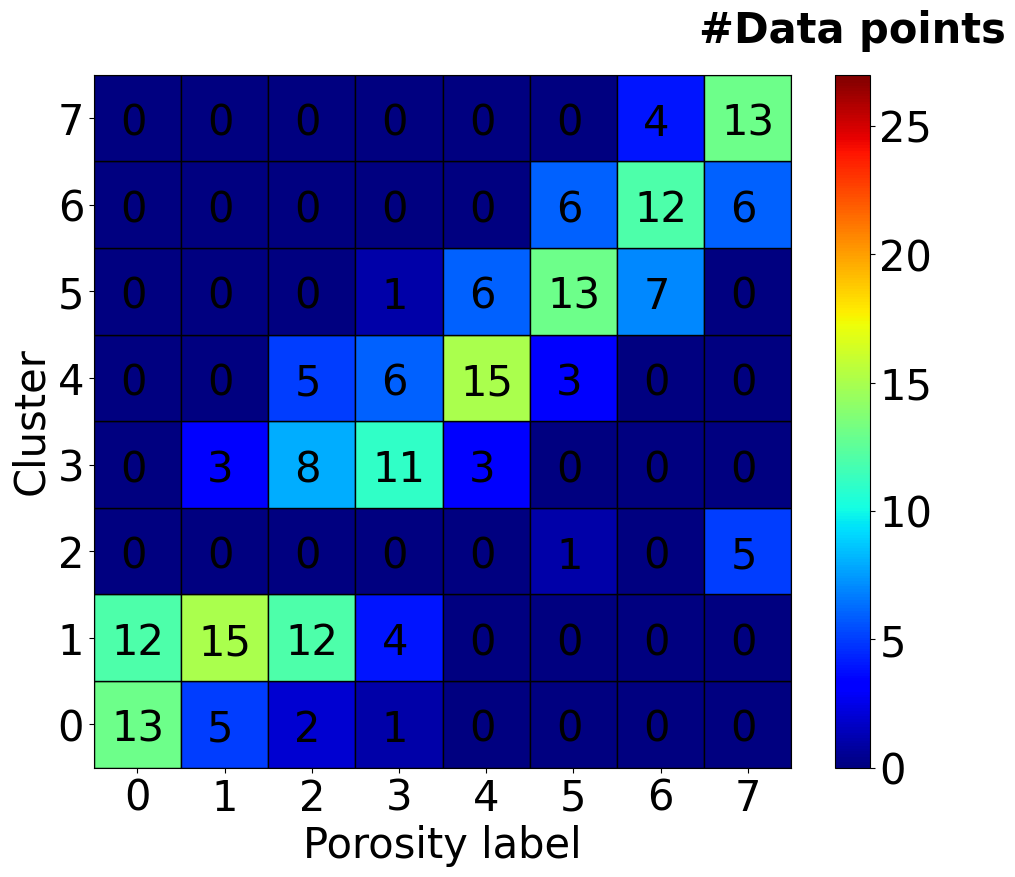

In [303]:
classifications_ind_train = model.classifications_ind

accuracy, accuracy_cluster = ConfusionMatrix(k, classifications_ind_train, data_porosity_label_train)

print("The training accuracy is %f" %(accuracy))
for i in range(len(accuracy_cluster)):
    print("The training accuracy for cluster %d is %f" %(i, accuracy_cluster[i]))

## **Metrics for the evaluation of the clustering performance on the training set.**

In [304]:
predicted_labels_train = np.zeros(data_porosity_label_train.shape[0], )
for classification in classifications_ind_train:
    for i in classifications_ind_train[classification]:
        predicted_labels_train[i] =  classification

pearson_corr_coeff_train = scipy.stats.pearsonr(data_porosity_label_train, predicted_labels_train)[0] #Calculation of Pearson correlation coefficient
mse_train = mean_squared_error(data_porosity_label_train, predicted_labels_train) #Calculation of mean squared error (MSE)

print("The Pearson correlation in the training se is %f" %(pearson_corr_coeff_train))
print("The MSE in the training se is %f" %(mse_train))

The Pearson correlation in the training se is 0.859203
The MSE in the training se is 1.463542


## **Implement the model to identify clusters in the testing set**

In [305]:
classifications_test, classifications_ind_test = model.predict(X_test)

## **Confusion matrix for the testing set.**

<ipython-input-302-071a2c81fea5>:100: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('jet')
<ipython-input-302-071a2c81fea5>:139: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


The testing accuracy is 0.130208
The testing accuracy for cluster 0 is 0.400000
The testing accuracy for cluster 1 is 0.714286
The testing accuracy for cluster 2 is 0.000000
The testing accuracy for cluster 3 is 0.571429
The testing accuracy for cluster 4 is 0.833333
The testing accuracy for cluster 5 is 0.857143
The testing accuracy for cluster 6 is 0.285714
The testing accuracy for cluster 7 is 0.166667


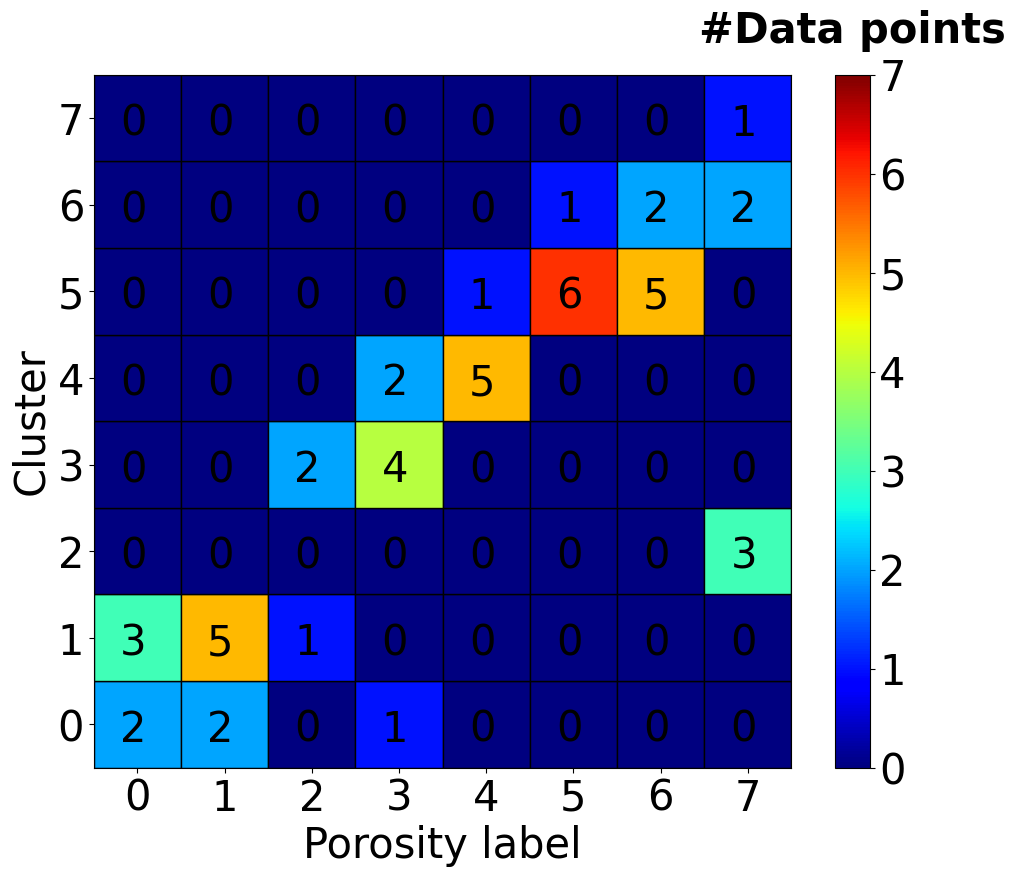

In [306]:
accuracy, accuracy_cluster = ConfusionMatrix(k, classifications_ind_test, data_porosity_label_test)

print("The testing accuracy is %f" %(accuracy))
for i in range(len(accuracy_cluster)):
    print("The testing accuracy for cluster %d is %f" %(i, accuracy_cluster[i]))

## **Metrics for the evaluation of the clustering performance on the testing set.**

In [307]:
predicted_labels_test = np.zeros(data_porosity_label_test.shape[0], )
for classification in classifications_ind_test:
    for i in classifications_ind_test[classification]:
        predicted_labels_test[i] =  classification

pearson_corr_coeff_test = scipy.stats.pearsonr(data_porosity_label_test, predicted_labels_test)[0] #Calculation of Pearson correlation coefficien
mse_test = mean_squared_error(data_porosity_label_test, predicted_labels_test) #Calculation of mean squared error (MSE)

print("The Pearson correlation in the testing set is %f" %(pearson_corr_coeff_test))
print("The MSE in the testing set is %f" %(mse_test))

The Pearson correlation in the testing set is 0.789237
The MSE in the testing set is 2.145833
